In [44]:
#AutoGluon: AutoML for Text, Image, and Tabular Data
#!python3 -m pip install -U pip
#!python3 -m pip install -U setuptools wheel

# Here we assume CUDA 10.1 is installed.  You should change the number
# according to your own CUDA version (e.g. mxnet_cu100 for CUDA 10.0).
#!python3 -m pip install -U "mxnet_cu101<2.0.0"
#!python3 -m pip install autogluon.tabular

#!pip install urllib3
#!pip install bokeh==2.0.1
#!pip install lightgbm
#!pip install catboost
#!pip install fastai==2.*
#!pip install xgboost
#!pip install mxnet --upgrade
#!pip install geopandas
#!pip install earthpy

#!pip install --upgrade matplotlib

In [68]:
from autogluon.tabular import TabularPredictor
import autogluon.core as ag
import os
import numpy as np
import math
import pandas as pd
import geopandas as gpd
import earthpy as et
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [46]:
from google.colab import drive
drive.mount('/content/drive')
google_drive_path = '/content/drive/My Drive/Colab_Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
#kfz_neukölln_path = os.path.join(google_drive_path, 'berlin_datathon_2021/data', "kfz_neukölln.csv")
kfz_neukölln_path = os.path.join(google_drive_path, 'berlin_datathon_2021/data', "kfz_neukölln_02.csv")
df_kfz_neukölln = pd.read_csv(kfz_neukölln_path)
df_kfz_neukölln.dtypes

lor                               object
name                              object
capacity                           int64
highway                           object
parking                           object
orientation                       object
position                          object
district                          object
Bezirksregion                     object
Prognoseraum                      object
lor size in m²                   float64
inhabitants_total                  int64
of_those_inhabitants_18+           int64
vehicles_overall                   int64
cars_only                          int64
vehicles_per_1000_inhabitants      int64
cars_per_1000_inhabitants          int64
geometry                          object
dtype: object

In [48]:
#drop_columns = ["source_capacity", "index_right", "district"]
#df_kfz_neukölln = df_kfz_neukölln.drop(columns=drop_columns)
#df_kfz_neukölln.dtypes

In [49]:
X_train, X_test = train_test_split(df_kfz_neukölln, test_size=0.24)
print(X_train.shape)
print(X_test.shape)

(3667, 18)
(1159, 18)


In [50]:
train_subsample_size = X_train.shape[0]#int(X_train.shape[0] * 0.8)#600  # subsample subset of data for faster demo, try setting this to much larger values
sample_X_train = X_train.sample(n=train_subsample_size, random_state=0)
#sample_X_train.head(6)

In [51]:
test_subsample_size = X_test.shape[0]#60
sample_X_test = X_test.sample(n=test_subsample_size, random_state=0)
y_test = sample_X_test["capacity"]  # values to predict
test_data_nolab = sample_X_test.drop(columns=["capacity"])  # delete label column to prove we're not cheating
#print(y_test[0:6])
#test_data_nolab.head(6)

In [52]:
nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 14,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.56, default=0.1),  # dropout probability (real-valued hyperparameter)
}

hyperparameters = {
    'NN': nn_options, 
    'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge',], 
    'CAT': {}, 'XGB': {}, 'FASTAI': {}, 'RF': [
      {'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, 
      {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
      {'criterion': 'mse', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}},], 
    'XT': [
      {'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, 
      {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
      {'criterion': 'mse', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}},
    ], 
    'KNN': [
      {'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}, 
      {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}},
    ],
}

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': 2048,
    'scheduler' : 'local',
    'searcher': 'bayesopt',
}

In [53]:
predictor_model_path_01 = os.path.join(google_drive_path, 'berlin_datathon_2021/model', "type_01")
predictor_model_path_02 = os.path.join(google_drive_path, 'berlin_datathon_2021/model', "type_02")
predictor_model_path_03 = os.path.join(google_drive_path, 'berlin_datathon_2021/model', "type_03")

In [14]:
#type 01
#predictor = TabularPredictor(
#              label="capacity", 
#              problem_type="regression", 
#              path=predictor_model_path_01
#            ).fit(
#                train_data=sample_X_train, 
#                presets='best_quality'
#            )

#type 02
#              label="capacity", 
#              problem_type="regression",
#              path=predictor_model_path_02
#            ).fit(
#                train_data=sample_X_train, 
#                presets='best_quality',
#                holdout_frac=0.24,
#                use_bag_holdout=True  
#            )

#type 03
#predictor = TabularPredictor(
#              label="capacity", 
#              problem_type="regression",
#              path=predictor_model_path_03
#            ).fit(
#                train_data=sample_X_train, 
#                presets='best_quality',
#                holdout_frac=0.24,
#                use_bag_holdout=True,
#                hyperparameters=hyperparameters,
#                hyperparameter_tune_kwargs=hyperparameter_tune_kwargs    
#            )            

In [54]:
predictor = TabularPredictor.load("/content/drive/My Drive/Colab_Notebooks/berlin_datathon_2021/model/type_02/")

In [55]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  regression
AutoGluon identified the following types of features:
('category', [])                    : 7 | ['lor', 'name', 'highway', 'orientation', 'position', ...]
('category', ['text_as_category'])  : 1 | ['geometry']
('float', [])                       : 1 | ['lor size in m²']
('int', [])                         : 6 | ['inhabitants_total', 'of_those_inhabitants_18+', 'vehicles_overall', 'cars_only', 'vehicles_per_1000_inhabitants', ...]
('int', ['binned', 'text_special']) : 6 | ['geometry.char_count', 'geometry.word_count', 'geometry.capital_ratio', 'geometry.digit_ratio', 'geometry.special_ratio', ...]
('int', ['bool'])                   : 2 | ['parking', 'district']
('int', ['text_ngram'])             : 2 | ['__nlp__.13', '__nlp__.52']


In [56]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2 -11.924606       0.713309   87.864726                0.000656           0.418100            2       True         11
1          CatBoost_BAG_L1 -11.966470       0.155557   35.411776                0.155557          35.411776            1       True          6
2          LightGBM_BAG_L1 -12.171080       0.650904   22.663348                0.650904          22.663348            1       True          4
3        LightGBMXT_BAG_L1 -12.171080       0.687819   25.173959                0.687819          25.173959            1       True          3
4     LightGBMLarge_BAG_L1 -12.270501       1.292022   50.915539                1.292022          50.915539            1       True         10
5      WeightedEnsemble_L3 -12.347835       7.052318  727.603699                

In [74]:
df_model_evaluation = pd.DataFrame({"model_names": [k for k in results["model_performance"].keys()],
                                    "rmse_scores": [-1 * v for v in results["model_performance"].values()]})

df_model_evaluation = df_model_evaluation.sort_values("rmse_scores")
y_axis_pos = np.arange(df_model_evaluation.shape[0])

low = df_model_evaluation.iloc[0]["rmse_scores"]
high = df_model_evaluation.iloc[df_model_evaluation.shape[0] - 1]["rmse_scores"]

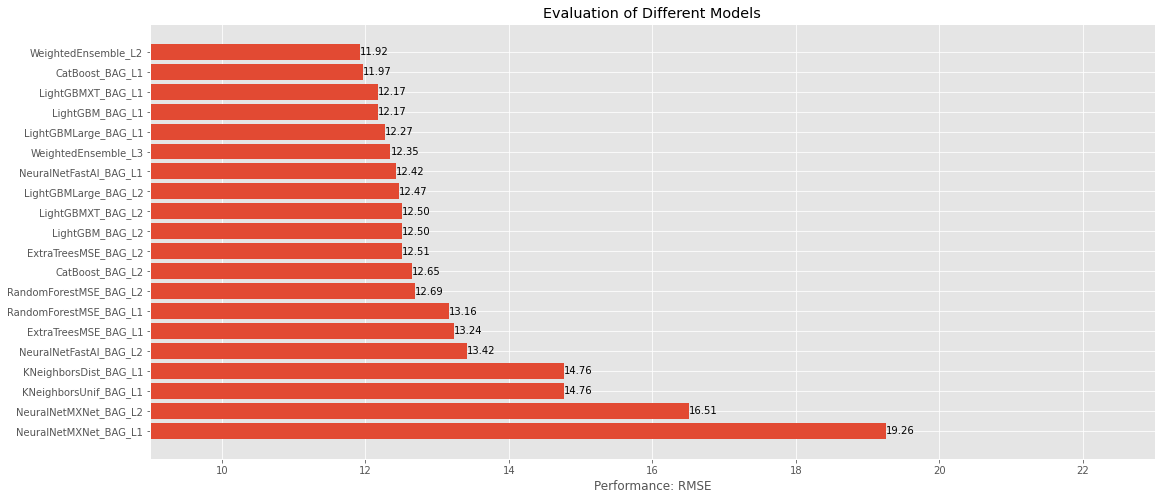

In [75]:
fig, ax = plt.subplots(figsize=(18, 8))
hbars = ax.barh(y_axis_pos, df_model_evaluation["rmse_scores"], align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(y_axis_pos, labels=df_model_evaluation["model_names"])
ax.set_xlabel('Performance: RMSE')
ax.set_title('Evaluation of Different Models')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%.2f')
ax.set_xlim(left=math.ceil(low-0.5*(high-low)), right=math.ceil(high+0.5*(high-low)))  # adjust xlim to fit labels

plt.show()

In [58]:
results["model_best"]

'WeightedEnsemble_L2'

In [59]:
y_pred = predictor.predict(test_data_nolab)
predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

{'mean_absolute_error': -8.164288829790301,
 'mean_squared_error': -125.25396106014027,
 'median_absolute_error': -6.59555721282959,
 'pearsonr': 0.421455101431674,
 'r2': 0.17579653012006613,
 'root_mean_squared_error': -11.191691608516543}

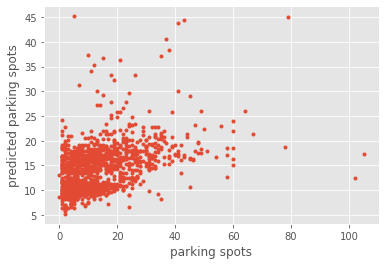

In [60]:
plt.plot(y_test, y_pred, '.')
plt.xlabel("parking spots")
plt.ylabel("predicted parking spots");